# Harmony EOSS L2SS API Tutorial

## Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT or Production environment, which 
will be used for this notebook by visiting [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov).
These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
    
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [15]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc
import json
import requests
import sys
import shutil
import xarray as xr
import cmr
import numpy as np
from podaac.subsetter import subset

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# GET TOKEN FROM CMR 
def get_token( url: str,client_id: str, user_ip: str,endpoint: str) -> str:
    try:
        token: str = ''
        username, _, password = netrc.netrc().authenticators(endpoint)
        xml: str = """<?xml version='1.0' encoding='utf-8'?>
        <token><username>{}</username><password>{}</password><client_id>{}</client_id>
        <user_ip_address>{}</user_ip_address></token>""".format(username, password, client_id, user_ip)
        headers: Dict = {'Content-Type': 'application/xml','Accept': 'application/json'}
        resp = requests.post(url, headers=headers, data=xml)
        
        response_content: Dict = json.loads(resp.content)
        token = response_content['token']['id']
    except:
        print("Error getting the token - check user name and password", sys.exc_info()[0])
    return token

### Find a granule for subsetting

Below we call out a specific granule (G1226018995-POCUMULUS) on which we will use the podaac L2 subsetter. Finding this information would complicate the tutorial- but po.daac has a tutorial available for using the CMR API to find collections and granules of interest. Please see the following tutorial for that information:

PODAAC_CMR.ipynb


In [16]:
collection = 'C1940473819-POCLOUD'
venue = 'prod'

In [17]:
# Defaults
cmr_root = 'cmr.earthdata.nasa.gov'
harmony_root = 'https://harmony.earthdata.nasa.gov'
edl_root = 'urs.earthdata.nasa.gov'

In [18]:
mode = cmr.queries.CMR_OPS
if venue == 'uat':
    cmr_root = 'cmr.uat.earthdata.nasa.gov'
    harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
    edl_root = 'uat.urs.earthdata.nasa.gov'
    mode = cmr.queries.CMR_UAT

print ("Environments: ")
print ("\t" + cmr_root)
print ("\t" + harmony_root)
print ("\t" + edl_root)

Environments: 
	cmr.earthdata.nasa.gov
	https://harmony.earthdata.nasa.gov
	urs.earthdata.nasa.gov


Now call the above function to set up Earthdata Login for subsequent requests

In [19]:
setup_earthdata_login_auth(edl_root)
token_url="https://"+cmr_root+"/legacy-services/rest/tokens"
token=get_token(token_url,'jupyter', '127.0.0.1',edl_root)

##  Subset of a PO.DAAC Granule

We can now build onto the root URL in order to actually perform a transformation.  The first transformation is a subset of a selected granule.  _At this time, this requires discovering the granule id from CMR_.  That information can then be appended to the root URL and used to call Harmony with the help of the `request` library.

Above we show how to find a granule id for processing.

**Notes:**
  The L2 subsetter current streams the data back to the user, and does not stage data in S3 for redirects. This is functionality we will be adding over time.
  It doesn't work with URS backed files, which is coming in the next few weeks
  it only works on the show dataset, but 
    

In [20]:
cmr_url = "https://"+cmr_root+"/search/granules.umm_json?collection_concept_id="+collection+"&sort_key=-start_date&token="+token
response = requests.get(cmr_url)
gid=response.json()['items'][0]['meta']['concept-id']
print(response.json()['items'][0])
print(gid)

# Find Bounding box
try:
    bounding_box = response.json()['items'][0]['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['BoundingRectangles'][0]

    north = bounding_box.get('NorthBoundingCoordinate')
    south = bounding_box.get('SouthBoundingCoordinate')
    west = bounding_box.get('WestBoundingCoordinate')
    east = bounding_box.get('EastBoundingCoordinate')

except KeyError:
    longitude_list = []
    latitude_list = []
    polygons = response.json()['items'][0]['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
    for polygon in polygons:
        points = polygon['Boundary']['Points']
        for point in points:
            longitude_list.append(point.get('Longitude'))
            latitude_list.append(point.get('Latitude'))

    north = max(latitude_list)
    south = min(latitude_list)
    west = min(longitude_list)
    east = max(longitude_list)
    
#compute a smaller bounding box 
north = north - abs(.05 * (north - south))
south = south + abs(.05 * (north - south))
west = west + abs(.05 * (east - west))
east = east - abs(.05 * (east - west))

longitude = "({}:{})".format(west, east)
latitude = "({}:{})".format(south, north)
    

{'meta': {'concept-type': 'granule', 'concept-id': 'G2196092705-POCLOUD', 'revision-id': 3, 'native-id': '20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0', 'provider-id': 'POCLOUD', 'format': 'application/vnd.nasa.cmr.umm+json', 'revision-date': '2022-01-05T23:15:39.264Z'}, 'umm': {'TemporalExtent': {'RangeDateTime': {'EndingDateTime': '2022-01-05T21:29:59.000Z', 'BeginningDateTime': '2022-01-05T21:25:00.000Z'}}, 'MetadataSpecification': {'URL': 'https://cdn.earthdata.nasa.gov/umm/granule/v1.6.4', 'Name': 'UMM-G', 'Version': '1.6.4'}, 'GranuleUR': '20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0', 'ProviderDates': [{'Type': 'Insert', 'Date': '2022-01-05T23:13:19.148Z'}, {'Type': 'Update', 'Date': '2022-01-05T23:13:19.148Z'}], 'SpatialExtent': {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -170.921, 'NorthBoundingCoordinate': 75.9, 'EastBoundingCoordinate': -107.605, 'SouthBoundingCoordinate': 52.682}], 'GPolygons': 

##  Download original granule


In [21]:
granule_query = cmr.queries.GranuleQuery(mode=mode)
granule_query.format('umm_json')
granule_umm_json_url = granule_query.concept_id(gid).token(token)._build_url()
response = requests.get(granule_umm_json_url)
response_text = json.loads(response.content)
urls = response_text.get('items')[0].get('umm').get('RelatedUrls')
print(urls)

def download_file(url):
    local_filename = "original_granule.nc"
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return local_filename

for x in urls:
    if x.get('Type') == "GET DATA" and x.get('Subtype') == None and '.bin' not in x.get('URL'):
        granule_url = x.get('URL')

download_file(granule_url) 
print(granule_url)

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc', 'Description': 'Download 20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc', 'Type': 'GET DATA'}, {'URL': 's3://podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc', 'Description': 'This link provides direct download access via S3 to the granule', 'Type': 'GET DATA VIA DIRECT ACCESS'}, {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_A-JPL-L2P-v2019.0/20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5', 'Description': 'Download 20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5', 'Type': 'EXTENDED METADATA'}, {'URL': 's3://podaac-ops-cumulus-public/MODIS_A-JPL-L2P-v2019.0/20220105212500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5', 'Description': 'This link provide

## Get lon, lat, time variables

In [22]:
from netCDF4 import Dataset

group = None

# Try to read group in file
with Dataset('original_granule.nc') as f:
    for g in f.groups:
        ds = xr.open_dataset('original_granule.nc', group=g)
        if len(ds.variables):
            group = g
        ds.close()
        
#ds = xr.open_dataset('original_granule.nc', engine="netcdf4")
if group:
    ds = xr.open_dataset('original_granule.nc', group=group)
else:
    ds = xr.open_dataset('original_granule.nc')
    
lat_var = None
lon_var = None

# If the lat/lon coordinates could not be determined, use l2ss-py get_coord_variable_names
if not lat_var or not lon_var:
    try:
        lat_var_names, lon_var_names = subset.get_coord_variable_names(ds)
        lat_var = lat_var_names[0]
        lon_var = lon_var_names[0]
    except ValueError:
        for coord_name, coord in ds.coords.items():
            if 'units' not in coord.attrs:
                continue
            if coord.attrs['units'] == 'degrees_north':
                lat_var = coord_name
            if coord.attrs['units'] == 'degrees_east':
                lon_var = coord_name
try:
    time_var = subset.get_time_variable_name(ds, ds[lat_var])
except Exception as ex:
    time_var = None
    
print(f'time_var={time_var}')
print(f'lat_var={lat_var}')
print(f'lon_var={lon_var}')

time_var=sst_dtime
lat_var=lat
lon_var=lon


##  Getting Variables for Collection

We use the python-cmr library to query cmr for umm-v associated to the collection. The python-cmr library (https://github.com/nasa/python_cmr) provides us ways to query cmr for different umm data. Then we select a variable that is within the granule to use.

In [23]:
collection_query = cmr.queries.CollectionQuery(mode=mode)
variable_query = cmr.queries.VariableQuery(mode=mode)

collection_res = collection_query.concept_id(collection).token(token).get()[0]
collection_associations = collection_res.get("associations")
variable_concept_ids = collection_associations.get("variables")

if variable_concept_ids is None and venue == 'uat':
    print('There are no umm-v associated with this collection and is uat env')
    sys.exit(0)

variables_res = variable_query.concept_id(variable_concept_ids[0:50]).get_all()
variables = [variable.get('name') for variable in variables_res]

original_variable = None

for x in variables:
    try:
        if x != lat_var and x != lon_var and x != time_var:
            new_path = None
            if group:
                if group in x:
                    new_path = "/".join(x.strip("/").split('/')[1:])
            
            if new_path:
                original_variable = x
                var_ds = ds[new_path]
            else:
                var_ds = ds[x]

            msk = np.logical_not(np.isnan(var_ds.data.squeeze()))
            true_exist = np.all((msk == False))
            if true_exist == False:
                if new_path:
                    variable = new_path
                else:
                    variable = x
                print(f'variable={variable}')
                break
    except Exception as ex:
        print(ex)
        pass

if ds[variable].size == 0:
    print("No data in subsetted region. Exiting")
    sys.exit(0)
ds.close()

variable=l2p_flags


In [24]:
subset_variable = variable
if original_variable:
    subset_variable = original_variable

subset_variable = subset_variable.replace('/', '%2F') 
bboxSubsetConfig = {
    'collection_id': collection,
    'ogc-api-coverages_version': '1.0.0',
    'variable': subset_variable,
    'granuleid': gid,
    'lat': latitude,
    'lon': longitude
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


Request URL https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/l2p_flags/coverage/rangeset?granuleid=G2196092705-POCLOUD&subset=lat(53.784855:74.73910000000001)&subset=lon(-167.7552:-110.61251)


In [25]:
with request.urlopen(bbox_url, timeout=180) as response, open('ogc_temp.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp.nc")

Content Size: 7872893
Downloaded request to ogc_temp.nc


Data variables:
    sst_dtime  (time, nj, ni) timedelta64[ns] ...
    l2p_flags  (time, nj, ni) int16 ...
2


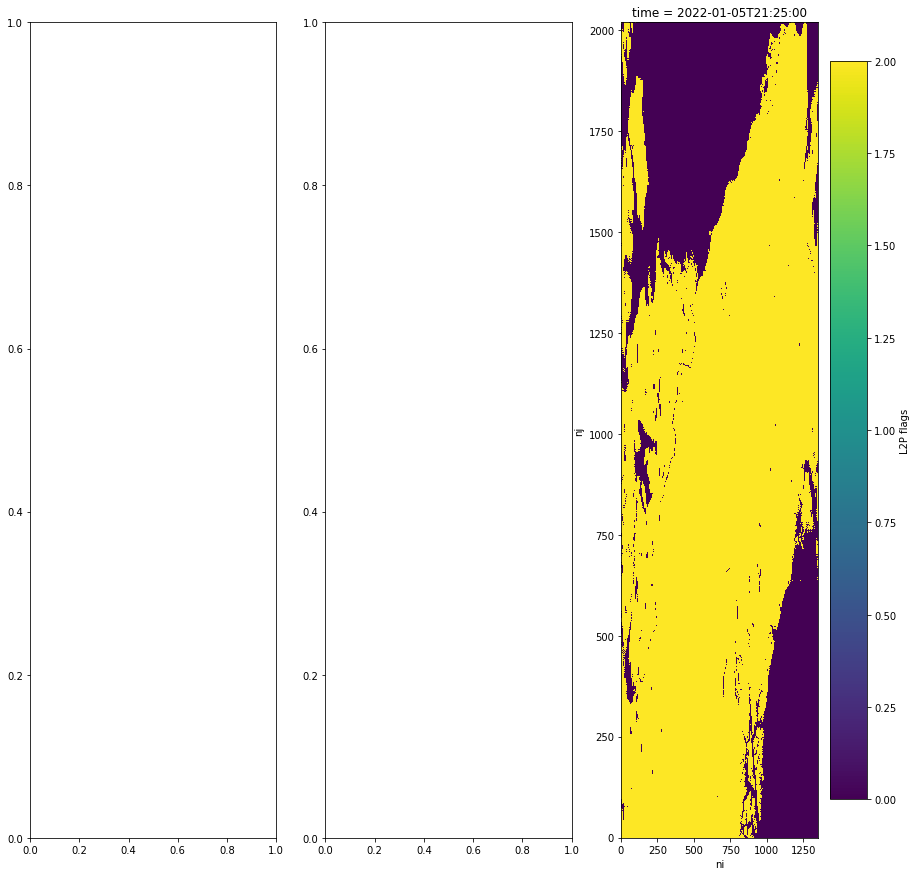

In [26]:
if group:
    ds = xr.open_dataset('ogc_temp.nc', engine="netcdf4", group=group)
else:
    ds = xr.open_dataset('ogc_temp.nc', engine="netcdf4")
    
import matplotlib.pyplot as plt
import math

print(ds.data_vars)
print(len(ds.data_vars))
fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(ds.data_vars)/3)))
fig.set_size_inches((15,15))

for count, xvar in enumerate(ds.data_vars):
    if ds[xvar].dtype == "timedelta64[ns]" or ds[xvar].dtype == "datetime64[ns]":
        continue
        #ds[xvar].astype('timedelta64[D]').plot(ax=axes[int(count/3)][count%3])
    #ds[xvar].plot(ax=axes[int(count/3)][count%3])
    ds[xvar].plot()

## Verify the subsetting worked


In [27]:
var_ds = ds[variable]
msk = np.logical_not(np.isnan(var_ds.data.squeeze()))

llat = ds[lat_var].where(msk)
llon = ds[lon_var].where(msk)

lat_max = llat.max()
lat_min = llat.min()

lon_min = llon.min()
lon_max = llon.max()

lon_min = (lon_min + 180) % 360 - 180
lon_max = (lon_max + 180) % 360 - 180

print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

if (lat_max <= north or np.isclose(lat_max, north)) and (lat_min >= south or np.isclose(lat_min, south)):
    print("Successful Latitude subsetting")
elif np.isnan(lat_max) and np.isnan(lat_min):
    print("Partial Lat Success - no Data")
else:
    assert False

if (lon_max <= east or np.isclose(lon_max,east)) and (lon_min >= west or np.isclose(lon_min, west)):
    print("Successful Longitude subsetting")
elif np.isnan(lon_max) and np.isnan(lon_min):
    print("Partial Lon Success - no Data")
else:
    assert False

ds.close()

<xarray.DataArray 'lon' ()>
array(-167.75471497)
<xarray.DataArray 'lon' ()>
array(-110.61260986)
<xarray.DataArray 'lat' ()>
array(53.784855, dtype=float32)
<xarray.DataArray 'lat' ()>
array(74.73905, dtype=float32)
Successful Latitude subsetting
Successful Longitude subsetting


## Compare original Granule to Subsetted Granule


In [28]:
if group:
    original_ds = xr.open_dataset("original_granule.nc", decode_times=False, decode_coords=False, engine="netcdf4", group=group)
    subsetted_ds = xr.open_dataset("ogc_temp.nc", decode_times=False, decode_coords=False, engine="netcdf4", group=group)
else:
    original_ds = xr.open_dataset("original_granule.nc", decode_times=False, decode_coords=False, engine="netcdf4")
    subsetted_ds = xr.open_dataset("ogc_temp.nc", decode_times=False, decode_coords=False, engine="netcdf4")
 
for in_var in subsetted_ds.data_vars.items():
    #compare attributes
    np.testing.assert_equal(in_var[1].attrs, original_ds[in_var[0]].attrs)
    
    # compare type and dimension names
    assert in_var[1].dtype == original_ds[in_var[0]].dtype
    assert in_var[1].dims == original_ds[in_var[0]].dims

print("Done")
original_ds.close()
subsetted_ds.close()

Done
